<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#План-по-выполнению-проекта" data-toc-modified-id="План-по-выполнению-проекта-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>План по выполнению проекта</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Обучение-BERT-модели" data-toc-modified-id="Обучение-BERT-модели-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Обучение BERT модели</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-обучению-BERT-модели" data-toc-modified-id="Вывод-по-обучению-BERT-модели-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Вывод по обучению BERT модели</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-исследованию" data-toc-modified-id="Вывод-по-исследованию-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод по исследованию</a></span></li></ul></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок. Постройте модель со значением метрики качества *F1* не меньше 0.75.

## Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## План по выполнению проекта

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

## Подготовка

In [1]:
# импортируем библиотеки 
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid') # darkgrid , whitegrid , dark, white , and ticks
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4

from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
!pip install -U spacy
import spacy
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')

import re
from tqdm import notebook

import torch
import transformers

from pathlib import Path

import lightgbm as lgb
from lightgbm import LGBMClassifier

import catboost as cbr
from catboost import CatBoostClassifier

from pymystem3 import Mystem

from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dotce\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dotce\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dotce\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# загрузим датасет 
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('e:/Яндекс.Практикум/Спринт 16 Машинное обучение для текстов/data/toxic_comments.csv')

In [3]:
# посмотрим на данные методом info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
# посмотрим на признаки и объекты
display(data)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [5]:
# взглянем на статистики
data.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Данные загружены. В датасете 159571 строк. Наблюдается дисбаланс классов 1 и 0 (видно по среднему значению единиц в размере 10,2% от датасета). Устраним дисбаланс классов, уменьшив выборку по выбивающемуся классу (возьмем одинаковое количество объектов с 0 и 1 в признаке "toxic") 

In [6]:
# отсортируем датасет по убыванию, сбросим индексы датасета
sorted_data = data.sort_values(by='toxic', ascending=False)
sorted_data.reset_index(drop=True, inplace=True)

#посчитаем количество токсичных комментариев (класс "1")
sorted_data['toxic'].sum()

#оставим в датасете первые 32450 строк (по 16225 каждого класса)
data_balanced = sorted_data.iloc[0:32450]
display(data_balanced)

print("Итого -1- в столбце 'toxic':", data_balanced['toxic'].sum())

,text,toxic
0,You sad cocksucker..stop editing my article ot...,1
1,"""\nGod, or whoever, whatever? I now decree you...",1
2,"""\n\n""""Everyone one who has written on this pa...",1
3,Albanians are terrorists \n\nI know that all a...,1
4,questions cuntface!,1
...,...,...
32445,UTCI\n\nYou run the NFL draft page poorly,0
32446,"""\n\n""""Although smaller than San Andreas, Libe...",0
32447,So this could be the start of a long-term issu...,0
32448,"""\n\n Scientific American """"Ask the Experts"""" ...",0


Итого -1- в столбце 'toxic': 16225


In [7]:
# создадим функцию для очистки текста
def text_cleaning(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dotce\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# создадим функцию для лемматизации текста
nlp = spacy.load("en_core_web_sm")
def lemmatize_spacy(text):
    doc = nlp(text)
    lemm_list = [token.lemma_ for token in doc]
    return " ".join(lemm_list)

In [9]:
# проверим работу функции на простом примере: функция работает верно!
lemmatize_spacy("When Sebastian Thrun started working on self-driving cars at")

'when Sebastian Thrun start work on self - drive car at'

In [10]:
# применим функцию lemmatize_spacy, добавив новый столбец с лемматизированным текстом в датасет 
data_lem_clear = data_balanced
data_lem_clear['lemmatized_text'] = data_lem_clear['text'].apply(lambda x: lemmatize_spacy(text_cleaning(x)))
display(data_lem_clear)

,text,toxic,lemmatized_text
0,You sad cocksucker..stop editing my article ot...,1,you sad cocksucker stop edit my article otherw...
1,"""\nGod, or whoever, whatever? I now decree you...",1,God or whoever whatever I now decree you the c...
2,"""\n\n""""Everyone one who has written on this pa...",1,everyone one who have write on this page be fa...
3,Albanians are terrorists \n\nI know that all a...,1,albanian be terrorist I know that all albanian...
4,questions cuntface!,1,question cuntface
...,...,...,...
32445,UTCI\n\nYou run the NFL draft page poorly,0,UTCI you run the NFL draft page poorly
32446,"""\n\n""""Although smaller than San Andreas, Libe...",0,although small than San Andreas Liberty City b...
32447,So this could be the start of a long-term issu...,0,so this could be the start of a long term issu...
32448,"""\n\n Scientific American """"Ask the Experts"""" ...",0,scientific American ask the Experts October th...


In [13]:
# подготовим признаки
features = data_lem_clear['lemmatized_text']
target = data_lem_clear['toxic']

In [14]:
# разобъем датасет на обучающую и тестовую выборки, применив стратификацию
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=12345, stratify=target)

if features_train.shape==target_train.shape and features_test.shape==target_test.shape:
    print('All is good: sample sizes are correct')
else:
    print('Error!!! Sample sizes are NOT correct')

features_train.shape, target_train.shape, features_test.shape, target_test.shape

All is good: sample sizes are correct


((24337,), (24337,), (8113,), (8113,))

In [15]:
# подготовка корпусов в кодировке Юникод для английского языка не требуется, но изменим названия переменных
corpus_train = features_train
corpus_test = features_test

# получим стоп-слова для английского языка
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dotce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
# получим TF-IDF для корпуса текста, stopwords - список стоп-слов
# ngram_range=(1, 1), max_df=1.0, min_df=1 - значения по умолчанию, которые можно поменять
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1), max_df=1.0, min_df=1)
features_tf_idf_train = count_tf_idf.fit_transform(corpus_train)
features_tf_idf_test = count_tf_idf.transform(corpus_test)

## Обучение

Проведем подбор гиперпараметров и обучение всех моделей: 'LinearRegression', 'CatBoostClassifier', 'LightGBM'. Критерием качества выступает F1.

### LinearRegression

In [17]:
lr = LogisticRegression(max_iter=500, n_jobs=-1)

In [18]:
%%time
lr.fit(features_tf_idf_train, target_train)

Wall time: 4.49 s


LogisticRegression(max_iter=500, n_jobs=-1)

In [19]:
%%time
lr_predictions = lr.predict(features_tf_idf_test)

Wall time: 2 ms


In [20]:
f1_test_lr = f1_score(target_test, lr_predictions)
print('F1 =', f1_test_lr)

F1 = 0.8890577507598784


### CatBoostClassifier

 Обучим, получим предсказания и проверим качество модели CatBoostClassifier с замером времени. Официальный сайт - https://catboost.ai/ 
 Ознакомительная статья по данной модели размещена по ссылке https://itnan.ru/post.php?c=1&p=594077
    
    CatBoost – библиотека, которая была разработана Яндексом в 2017 году, представляет разновидность семейства алгоритмов Boosting и является усовершенствованной реализацией Gradient Boosting Decision Trees (GBDT). CatBoost имеет поддержку категориальных переменных и обеспечивает высокую точность. Стоит сказать, что CatBoost решает проблему смещения градиента (Gradient Bias) и смещения предсказания (Prediction Shift), это позволяет уменьшить вероятность переобучения и повысить точность алгоритма.

In [21]:
# подберем параметры с помощью GridSearch

model_CBC = CatBoostClassifier()

parameters = {'depth'         : [6],
              'learning_rate' : [0.2],
              'iterations'    : [250]
              }

grid = GridSearchCV(estimator=model_CBC, param_grid = parameters, cv = 5, scoring='f1')
grid.fit(features_tf_idf_train, target_train)

print(" --------------------------------------------------------------------------" )
print(" --------------------------------------------------------------------------" )
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

0:	learn: 0.6178073	total: 474ms	remaining: 1m 57s
1:	learn: 0.5770923	total: 751ms	remaining: 1m 33s
2:	learn: 0.5574141	total: 1.03s	remaining: 1m 25s
3:	learn: 0.5402105	total: 1.32s	remaining: 1m 21s
4:	learn: 0.5214836	total: 1.6s	remaining: 1m 18s
5:	learn: 0.5066169	total: 1.89s	remaining: 1m 16s
6:	learn: 0.4988642	total: 2.17s	remaining: 1m 15s
7:	learn: 0.4903587	total: 2.45s	remaining: 1m 14s
8:	learn: 0.4814981	total: 2.73s	remaining: 1m 13s
9:	learn: 0.4750492	total: 3.02s	remaining: 1m 12s
10:	learn: 0.4660854	total: 3.3s	remaining: 1m 11s
11:	learn: 0.4595229	total: 3.58s	remaining: 1m 10s
12:	learn: 0.4550387	total: 3.85s	remaining: 1m 10s
13:	learn: 0.4490161	total: 4.12s	remaining: 1m 9s
14:	learn: 0.4444499	total: 4.39s	remaining: 1m 8s
15:	learn: 0.4391780	total: 4.66s	remaining: 1m 8s
16:	learn: 0.4352187	total: 4.93s	remaining: 1m 7s
17:	learn: 0.4313217	total: 5.21s	remaining: 1m 7s
18:	learn: 0.4281972	total: 5.47s	remaining: 1m 6s
19:	learn: 0.4236805	total: 5.

In [22]:
# применим полученные лучшие параметры
cat_model_selected_options = CatBoostClassifier(depth=6, learning_rate=0.2, iterations=250, verbose=10)

In [23]:
%%time
cat_model_selected_options.fit(features_tf_idf_train, target_train)

0:	learn: 0.6182403	total: 323ms	remaining: 1m 20s
10:	learn: 0.4627956	total: 3.37s	remaining: 1m 13s
20:	learn: 0.4192248	total: 6.46s	remaining: 1m 10s
30:	learn: 0.3897459	total: 9.52s	remaining: 1m 7s
40:	learn: 0.3676017	total: 12.6s	remaining: 1m 4s
50:	learn: 0.3508883	total: 15.8s	remaining: 1m 1s
60:	learn: 0.3340395	total: 18.8s	remaining: 58.3s
70:	learn: 0.3204212	total: 21.8s	remaining: 55.1s
80:	learn: 0.3086254	total: 24.9s	remaining: 51.9s
90:	learn: 0.2978787	total: 27.9s	remaining: 48.8s
100:	learn: 0.2882928	total: 31.2s	remaining: 46s
110:	learn: 0.2807230	total: 34.2s	remaining: 42.8s
120:	learn: 0.2740187	total: 37.3s	remaining: 39.7s
130:	learn: 0.2686426	total: 40.3s	remaining: 36.6s
140:	learn: 0.2627370	total: 43.3s	remaining: 33.5s
150:	learn: 0.2573697	total: 46.5s	remaining: 30.5s
160:	learn: 0.2527806	total: 49.6s	remaining: 27.4s
170:	learn: 0.2475966	total: 52.6s	remaining: 24.3s
180:	learn: 0.2438742	total: 55.6s	remaining: 21.2s
190:	learn: 0.2393290	

In [24]:
%%time
cbc_predictions = cat_model_selected_options.predict(features_tf_idf_test)

Wall time: 173 ms


In [25]:
f1_test_cbc = f1_score(target_test, cbc_predictions)
print('F1 =', f1_test_cbc)

F1 = 0.893106119287374


### LightGBM

Обучим, получим предсказания и проверим качество модели LightGBM с замером времени.

LightGBM, сокращение от Light Gradient Boosting Machine, представляет собой бесплатную распределенную структуру повышения градиента с открытым исходным кодом для машинного обучения, первоначально разработанную Microsoft.

Официальная страница https://lightgbm.readthedocs.io/en/v3.3.2/

In [26]:
# подберем параметры с помощью GridSearch

params = {
    'max_depth': [10],
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'num_leaves': [8]
}

grid = GridSearchCV(lgb.LGBMRegressor(random_state=0), params, cv=5, scoring='f1')
grid.fit(features_tf_idf_train, target_train)

print(" --------------------------------------------------------------------------" )
print(" --------------------------------------------------------------------------" )
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

 --------------------------------------------------------------------------
 --------------------------------------------------------------------------
 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(max_depth=10, n_estimators=1000, num_leaves=8, random_state=0)

 The best score across ALL searched params:
 nan

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'num_leaves': 8}


In [27]:
params = {
    'metric': 'f1',
    'max_depth': 10, 
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'num_leaves': 8,
    'verbose': 0
}
lgbm_model_selected_options = LGBMClassifier(**params)

In [28]:
%%time
lgbm_model_selected_options.fit(features_tf_idf_train, target_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Wall time: 12.2 s


LGBMClassifier(max_depth=10, metric='f1', n_estimators=1000, num_leaves=8,
               verbose=0)

In [29]:
%%time
lgbm_predictions = lgbm_model_selected_options.predict(features_tf_idf_test)

Wall time: 154 ms


In [30]:
f1_test_lgbm = f1_score(target_test, lgbm_predictions)
print('F1 =', f1_test_lgbm)

F1 = 0.8987616494318907


### Обучение BERT модели

In [31]:
# подготовим новый датасет из сбалансированного по классам датасета data_balanced, оставив в нем 1000 строк
data_balanced_lem_1000 = data_lem_clear.sample(1000).reset_index(drop=True)

In [32]:
# проверим баланс классов и убедимся, что выборка содержит примерно по половине каждого из классов "0" и "1" в 'toxic'
data_balanced_lem_1000['toxic'].sum()
display(data_balanced_lem_1000)

,text,toxic,lemmatized_text
0,Maybe when you stop trying to tell me what to ...,1,maybe when you stop try to tell I what to do w...
1,"""there are too many unreferenced remarks purpo...",0,there be too many unreferenced remark purport ...
2,", you stupid ass fucker, retarded whore, incom...",1,you stupid ass fucker retarded whore incompete...
3,Your bot \n\nYour bot keeps tagging the articl...,0,your bot your bot keep tag the article for Now...
4,Greg's Apology\n\nA while back I added Greg's ...,0,Greg s Apology A while back I add Greg s on ai...
...,...,...,...
995,"""\n\n WikiProject Germany Invitation \n\nHello...",0,WikiProject Germany Invitation hello Stilfehle...
996,Yeah yeah yeah... get a life faggot. 67.176.98.94,1,yeah yeah yeah get a life faggot
997,I wasn't fucking joking asshole so I don't see...,1,I wasn t fuck joke asshole so I don t see why ...
998,Why won't you leave me alone? Why do you keep...,1,why won t you leave I alone why do you keep st...


In [33]:
# введем параметры для подбора, т.к. модель требовательна к ресурсам компьютера
objects = 600 # количество объектов, которое оставим для расчета, но не более 1000
max_length_token = 40 # максимальная длина токена, не более 512
batch_size = 2 # размер батчей

# оставим только часть записей, чтобы ускорить процесс расчетов
df_tweets = data_balanced_lem_1000.sample(objects).reset_index(drop=True)

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenized = df_tweets['lemmatized_text'].apply(lambda x: tokenizer.encode
                                               (x, add_special_tokens=True, truncation=True, max_length=max_length_token))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")

embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

features = np.concatenate(embeddings)
target = df_tweets['toxic']

# обучим и протестируем модель
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.25)
model = LogisticRegression()
model.fit(train_features, train_target)
print(model.score(test_features, test_target))

  0%|          | 0/300 [00:00<?, ?it/s]

0.6666666666666666


#### Вывод по обучению BERT модели
BERT модель является прогрессивным методом, но требует значительных вычислительных ресурсов. В данном проекте ввиду ограничений (существенное сокращение базы данных для BERT, низкие настройки параметров) модель не смогла показать высокий результат.

## Выводы

Мы обучили и протестировали метрикой F1 три модели: 'LinearRegression', 'CatBoostClassifier', 'LightGBM'. Сведем полученные результаты в таблицу и визуализируем метрику F1

In [34]:
# создадим таблицу, в которую запишем результаты обучения моделей
results = pd.DataFrame({
    'Model' : ['LinearRegression', 'CatBoostClassifier', 'LightGBM'], 
    'F1_test' : [f1_test_lr, f1_test_cbc, f1_test_lgbm]
})

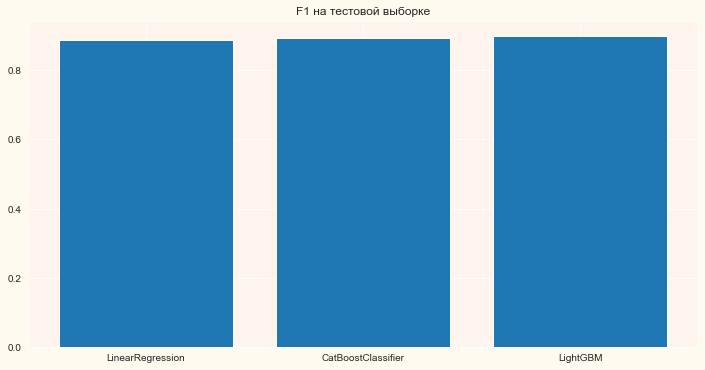

In [35]:
# представим на диаграмме данные по параметру 'F1 на тестовой выборке'
fig, ax = plt.subplots()
x = results['Model']
y = results['F1_test']
ax.bar(x, y)
ax.set_title('F1 на тестовой выборке')
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.show()

### Вывод по исследованию
**В результате проведения исследования достигнута цель проекта - обучена модель, которая способна классифицировать комментарии на позитивные и негативные, при этом значение метрики качества F1 превышает требуемые 0.75! `LinearRegression`, `CatBoostClassifier`, `LightGBM` значительно превзошли требуемую метрику качества. Лучшей по качеству оказалась модель `LightGBM`** 
    
    1) LightGBM (гиперпараметры)
    params = {
        'metric': 'f1',
        'max_depth': 10, 
        'learning_rate': 0.1,
        'n_estimators': 1000,
        'num_leaves': 8,
        'verbose': 0}